In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache, reduce
from nltk.corpus import stopwords
import pickle

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

You should consider upgrading via the '/home/alexna/work/projects/bootcamp_kaggle/venv/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /home/alexna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('train_ml.csv')
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1.0,16.02.2017 16:10
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2.0,13.12.2016 1:05
2,alfabank,Здравствуйте!Ранее уже оставлял отзыв о вашем ...,NaN,28.06.2019 13:54
3,vtb,Обращаюсь к Вам с жалобой на незаконное списан...,NaN,15.07.2020 14:54
4,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2.0,04.08.2020 6:38
...,...,...,...,...
74995,trust,Три года длится эпопея с закрытием кредитной к...,1.0,26.10.2016 11:03
74996,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2.0,01.02.2020 21:07
74997,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1.0,14.06.2016 16:03
74998,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3.0,21.04.2020 8:24


In [77]:
df.drop(['date'], axis=1, inplace=True)
df = df.astype({'grades': 'int32'})

In [6]:
df.describe(include='all')

,bank,feeds,grades,date
count,75000,75000,51476.000000,75000
unique,69,74994,NaN,73972
top,sberbank,Не дают погасить задолженность по кредиту.В 20...,NaN,02.11.2020 20:51
freq,12898,2,NaN,3
mean,NaN,NaN,2.395097,NaN
std,NaN,NaN,1.741879,NaN
min,NaN,NaN,1.000000,NaN
25%,NaN,NaN,1.000000,NaN
50%,NaN,NaN,1.000000,NaN
75%,NaN,NaN,5.000000,NaN


In [3]:
df_no_grades = df[df['grades'].isna()]

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
df = df.astype({'grades': 'int32'})
df.reset_index(inplace=True, drop=True)
df

,bank,feeds,grades,date
0,ubrr,"Много лет являюсь клиентом этого банка, но пос...",1,2017-02-16 16:10:00
1,fk_otkritie,"Г. Ростов-на-Дону, ул. Ленина, 48. Были 10.12....",2,2016-12-13 01:05:00
2,promsvyazbank,"Имею потребительский кредит, взятый в Связь-ба...",2,2020-08-04 06:38:00
3,homecreditbank,Хочу выразить глубокую благодарность всем сотр...,5,2015-04-19 20:11:00
4,vtb,"6 марта 2019г. В 10:33 при проходе в метро ""Ку...",2,2019-03-28 18:36:00
...,...,...,...,...
51471,trust,Три года длится эпопея с закрытием кредитной к...,1,2016-10-26 11:03:00
51472,fk_otkritie,"Являлся клиентом Бинбанка, пока после слияния ...",2,2020-02-01 21:07:00
51473,sberbank,8 мая 2016 г. мною вносились деньги на банковс...,1,2016-06-14 16:03:00
51474,uralsib,Здравствуйте! Сегодня 21.04.2020 захожу в моби...,3,2020-04-21 08:24:00


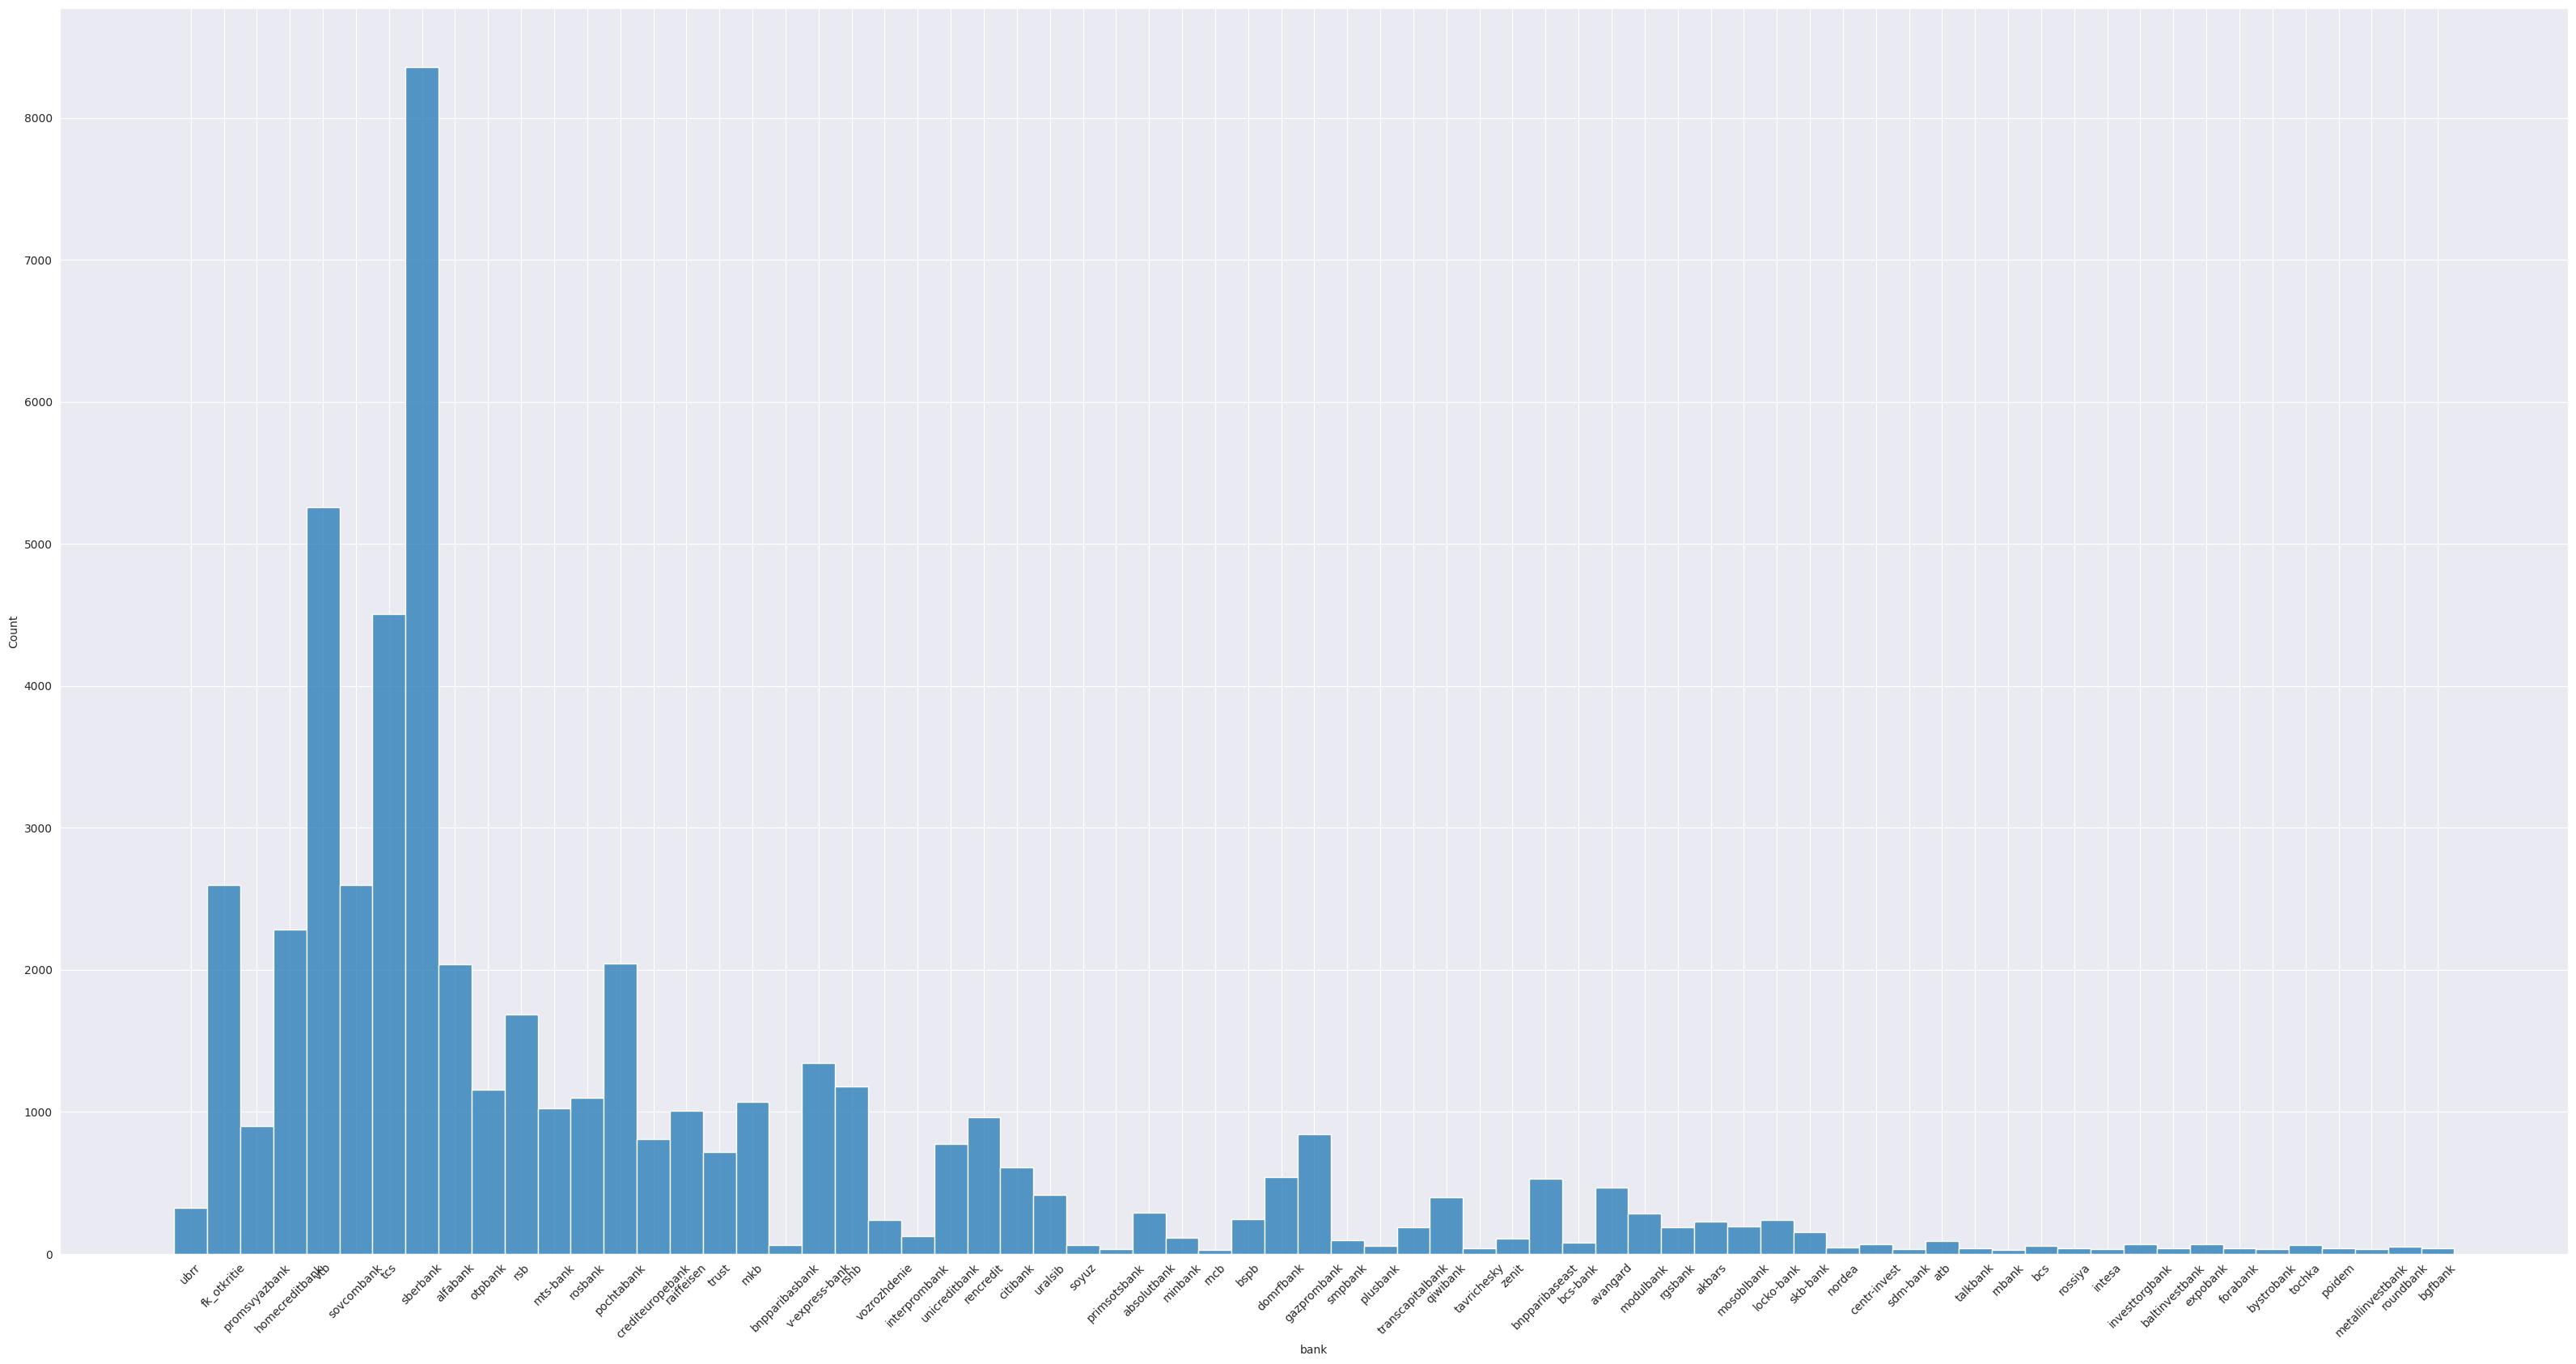

In [18]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'), x=df.bank, )
plt.xticks(rotation=45)
plt.show()

In [25]:
len(df['bank'].unique())

69

In [29]:
df['bank'].value_counts()

225.0

<AxesSubplot: xlabel='bank', ylabel='Count'>

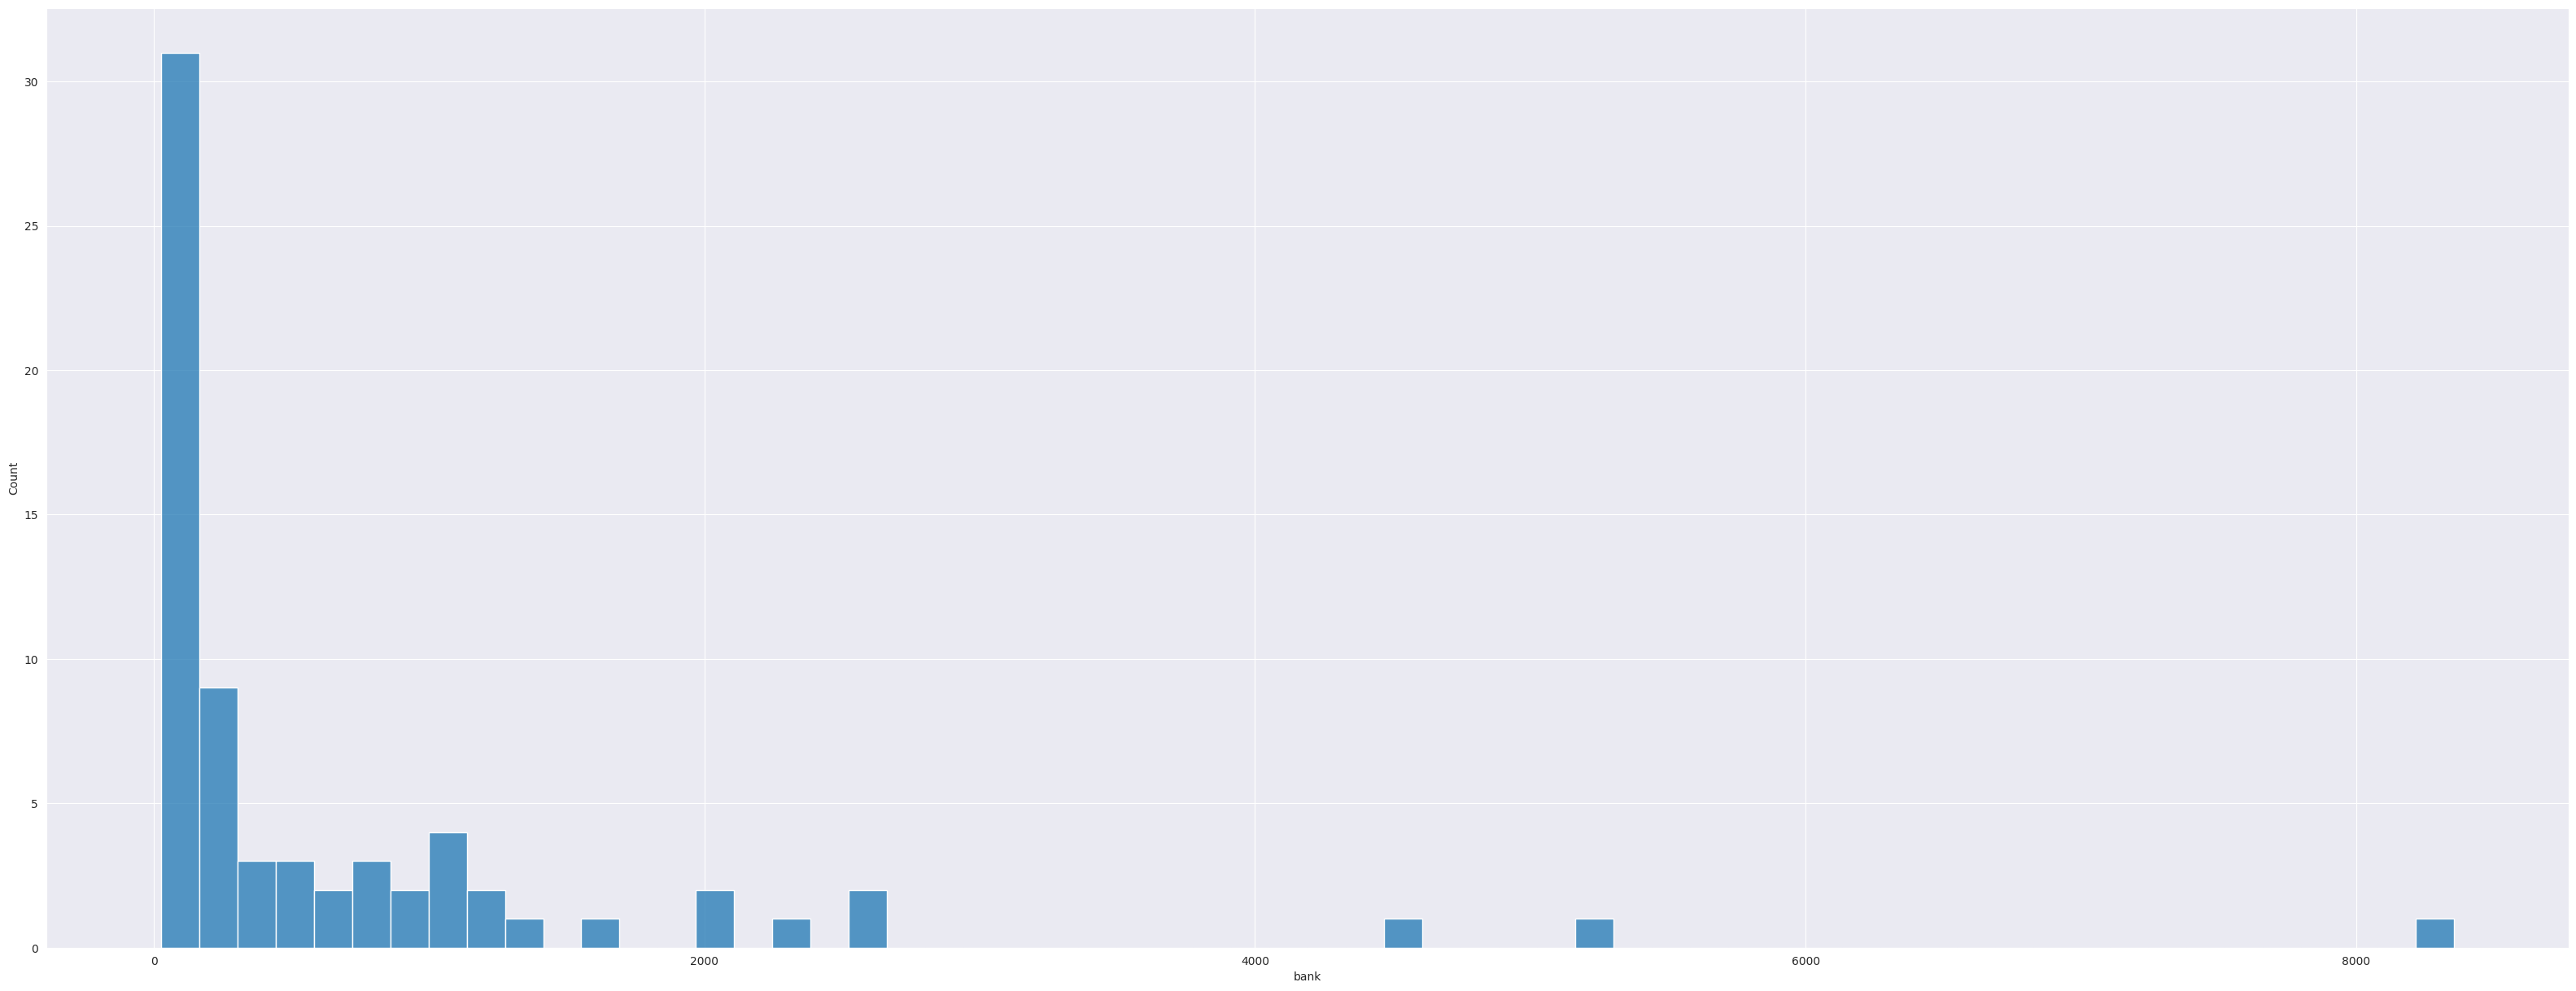

In [37]:
plt.figure(figsize=(40,15))
sns.histplot(data=df['bank'].value_counts(), bins=60)

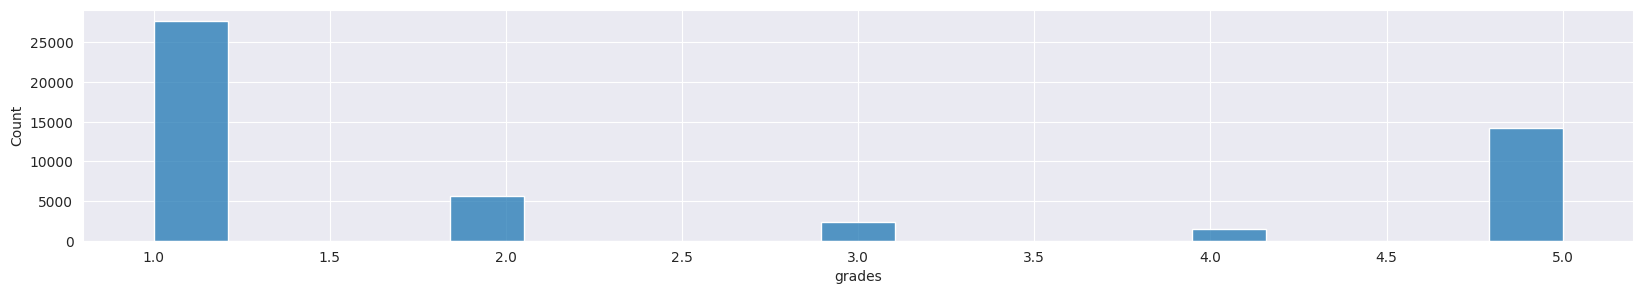

In [42]:
df.grades.value_counts().sort_index()
plt.figure(figsize=(20, 3))
sns.histplot(data=df, x=df.grades, )
plt.show()

In [5]:
df['sym_len'] = df.feeds.apply(len)
df['word_len'] = df.feeds.apply(lambda x: len(x.split()))

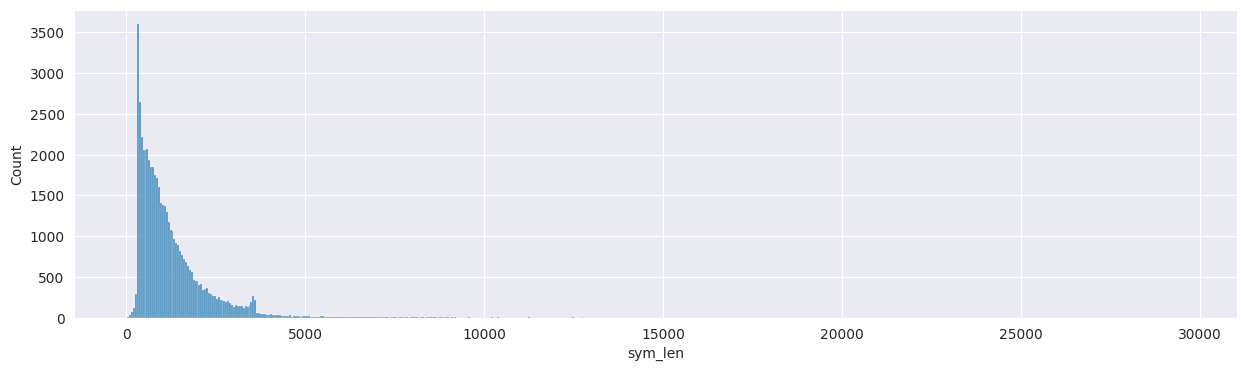

In [45]:
plt.figure(figsize=(15, 4))
sns.histplot(data=df.sym_len)
plt.show()

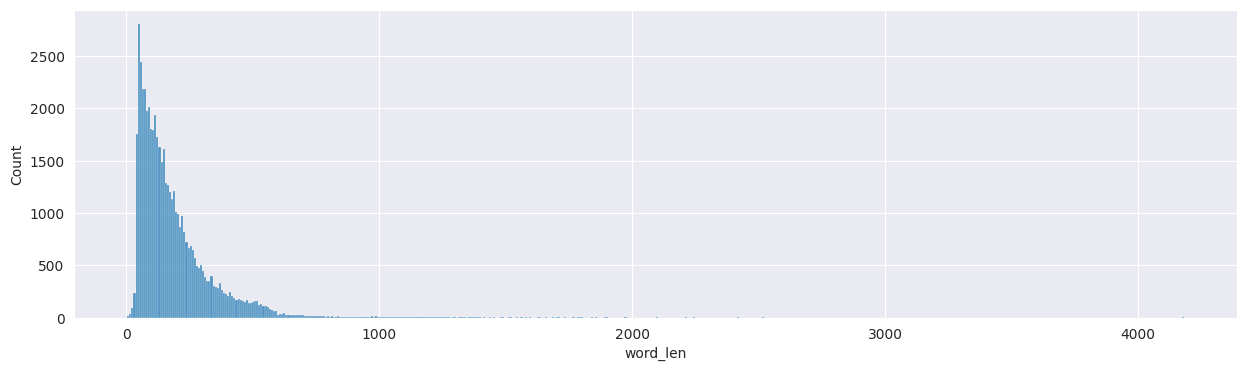

In [46]:
plt.figure(figsize=(15, 4))
sns.histplot(data=df.word_len)
plt.show()

In [11]:
m = MorphAnalyzer()

In [12]:
mystopwords = stopwords.words('russian')
mystopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [10]:
gen_negtopos = round(df[df["grades"] <= 3].value_counts().sum() / df[df["grades"] > 3].value_counts().sum(), 2)

def get_emotion(word, freq = 0):
    df_p = df[df['feeds'].str.contains(word)]
    negtopos = round(df_p[df_p["grades"] <= 3].value_counts().sum() / df_p[df_p["grades"] > 3].value_counts().sum(), 2)
    if negtopos > 1.3*gen_negtopos:
        return -1
    elif negtopos < gen_negtopos/1.3:
        return +1
    else:
        return 0

In [13]:
df_stop_wrong = pd.DataFrame(columns=["word", "emotion"])
for w in mystopwords:
    em = get_emotion(w)
    df_stop_wrong.loc[len(df_stop_wrong)] = {'word':w, 'emotion': em}

In [67]:
df_stop_wrong[df_stop_wrong['emotion'] != 0]

,word,emotion
4,что,-1
10,как,-1
15,так,-1
16,его,-1
19,ты,-1
...,...,...
144,такой,-1
146,более,-1
147,всегда,1
149,всю,-1


In [14]:
stopwords_filtered = df_stop_wrong.loc[df_stop_wrong['emotion'] == 0, 'word'].tolist()

In [27]:
import pickle
with open("stopwords_filtered", "wb") as fp:
    pickle.dump(stopwords_filtered, fp)

In [29]:
del df_stop_wrong

In [7]:
def get_capitalized_words(text):
    #regex_capital_letters = re.compile("(?:([А-Я]{3,})|(НЕ)|(ДА))")
    regex_capital_letters = re.compile("([А-Я]{4,}|НЕ|ДА)")
    try:
        found = regex_capital_letters.findall(text)
        if len(found) == 0:
            return []
        return found
    except:
        return []

In [90]:

df['capswords'] = df.loc[:, 'feeds'].apply(get_capitalized_words)

In [6]:
def get_exclamation(text):
    regex_exclamation = re.compile("(\!+|\?+|\.{3}|\:\(|\:\)|\){2,}|\({2,})")
    try:
        found = regex_exclamation.findall(text)
        if len(found) == 0:
            return []
        return found
    except:
        return []

In [91]:

df['exclamation'] = df.loc[:, 'feeds'].apply(get_exclamation)

In [12]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


def remove_stopwords(lemmas, stopwords = stopwords_filtered):
    return [w for w in lemmas if not w in stopwords and len(w) > 1]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [17]:
with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['feeds']), total=len(df)))

df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 51476/51476 [06:11<00:00, 138.56it/s]


,bank,feeds,grades,date,sym_len,word_len,capswords,exclamation,lemmas
8893,crediteuropebank,Доброго времени суток. Хотелось бы понять один...,2,2014-06-16 21:17:00,831,123,"[КРЕДИТ, ЕВРОПА, БАНК]",None,добрый время сутки хотеться понять один момент...
35762,pochtabank,"Самый худший банк, в котом когда-либо обслужив...",1,2020-07-11 16:50:00,1153,172,[ОДОБРЕНА],None,самый плохой банк кот когда либо обслуживаться...
31474,vozrozhdenie,"Речь пойдёт о Волжском филиале Банка ""Возрожде...",5,2006-10-24 09:25:00,1415,205,None,"[!, !, !]",речь пойда так волжский филиал банк возрождени...
44851,vtb,Я с мужем получаем зарплату на карту ВТБ с мая...,1,2018-03-27 09:37:00,483,73,None,None,муж получать зарплата карта втб май год недавн...
47866,pochtabank,Получила предложение оформить кредитную карту ...,5,2016-08-05 14:26:00,578,80,None,None,получить предложение оформить кредитный карта ...


In [18]:
from collections import Counter
df['lemma_count'] = df['lemmas'].str.split().apply(lambda x: Counter(x))
df['lemma_count'].head(20)

0     {'год': 1, 'являться': 1, 'клиент': 5, 'это': ...
1     {'ростов': 1, 'дон': 1, 'ул': 1, 'ленин': 1, '...
2     {'иметь': 1, 'потребительский': 1, 'кредит': 2...
3     {'хотеть': 1, 'выразить': 1, 'глубокий': 1, 'б...
4     {'март': 3, 'проход': 1, 'метро': 3, 'курский'...
5     {'познакомиться': 1, 'втб': 4, 'конец': 1, 'го...
6     {'офис': 1, 'совкомбанк': 1, 'снимать': 1, 'со...
7     {'добрый': 1, 'день': 1, 'терять': 1, 'клиент'...
8     {'добрый': 1, 'день': 2, 'хотеть': 1, 'обратит...
9     {'август': 1, 'откликнуться': 1, 'предложение'...
10    {'зайти': 1, 'альфа': 1, 'клик': 1, 'обнаружит...
11    {'март': 2, 'магнит': 2, 'расплатиться': 1, 'к...
12    {'день': 1, 'обратиться': 1, 'офис': 1, 'банк'...
13    {'здравствуйте': 1, 'иметь': 1, 'обязательство...
14    {'ценить': 1, 'сотрудничество': 1, 'банк': 4, ...
15    {'здравствуйте': 1, 'являться': 2, 'клиент': 2...
16    {'примерно': 1, 'приложение': 1, 'возникнуть':...
17    {'решить': 1, 'перевести': 1, 'свой': 2, '

In [19]:
df.to_csv("train_lemmas.csv")

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vc_counter = CountVectorizer(ngram_range=(1, 1))
vc_count = vc_counter.fit_transform(df['lemmas'])

vc_frequence = pd.DataFrame(
  # получаем словарь из CountVectorizer
	# c помощью .get_feature_names_out()
  {'word' : vc_counter.get_feature_names_out(),
  # получаем частотность слов
	# находя сумму компонент векторов
  'frequency' : np.array(vc_count.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

vc_frequence.reset_index(drop=True, inplace=True)
vc_frequence.head(50)

,word,frequency
0,банк,189653
1,карта,90697
2,день,48599
3,кредит,47845
4,сотрудник,46579
5,который,40967
6,деньга,39456
7,клиент,37730
8,отделение,36037
9,мочь,33215


In [ ]:
y_train = df.grades
y_train = y_train.reset_index().drop(columns='index')
y_train

In [101]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 2)) # используем уни-, биграммы
bow = vec.fit_transform(lemmas)
clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True)

CPU times: user 19.3 s, sys: 752 ms, total: 20 s
Wall time: 20.1 s


In [104]:
# небольшой трюк: будем обучаться частями
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 10) # разобъем на 10 частей
# и подмешаем к каждому куску случайных объектов
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=1000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(bow[chunk, :], y_train.iloc[chunk])

  0%|          | 0/10 [00:00<?, ?it/s]/home/alexna/work/projects/bootcamp_kaggle/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 10%|█         | 1/10 [02:13<19:59, 133.24s/it]/home/alexna/work/projects/bootcamp_kaggle/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 2/10 [04:28<17:55, 134.39s/it]/home/alexna/work/projects/bootcamp_kaggle/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

In [119]:
pickle.dump(clf, open('cfl1.pkl', 'wb'))

In [105]:
pred = clf.predict(vec.transform(lemmas))


In [117]:
pickle.dump(vec.vocabulary_, open('vectorizer1.pkl', 'wb'))


In [118]:
vec_reload = TfidfVectorizer(decode_error='replace', vocabulary=pickle.load(open('vectorizer1.pkl', 'rb')))

In [ ]:
pred = clf.predict(vec.transform(lemmas))

In [107]:
from sklearn.metrics import f1_score
f1_score(y_train, pred, average='micro')

0.7700481777915922

In [2]:
test = pd.read_csv('new_test_ml.csv', index_col=0)
test

,bank,feeds,date
0,sberbank,Оформляем ипотеку в Сбербанке. 22.06.2020 были...,01.07.2020 10:53
1,alfabank,Краткое содержание: не рекомендую брать кредит...,20.06.2019 13:19
2,v-express-bank,"Добрый день, уважаемые сотрудники службы контр...",20.02.2016 11:46
3,homecreditbank,"Обращался за получением карты ""Зеленая польза""...",06.05.2019 15:48
4,vtb,20.05.2016 обратилась в отделение банка на про...,23.05.2016 15:41
...,...,...,...
17215,sberbank,"21.09.2018 в 15:26:56, я, О-ва К. К., снимала ...",22.09.2018 16:08
17216,homecreditbank,"Наверняка не засчитают, но тем не менее. Нужна...",06.10.2011 9:35
17217,interprombank,"15.08.2019 я, как физ.лицо обратилась в офис н...",21.08.2019 14:13
17218,otpbank,"У банка есть рекламный продукт-игра ""Мои рыбки...",29.05.2020 16:12


In [3]:
test.drop(columns=['date'], axis=1, inplace=True)

In [4]:
stopwords_filtered = []
with open("stopwords_filtered", "rb") as fp:  # Unpickling
    stopwords_filtered = pickle.load(fp)

In [9]:
test['capswords'] = test.loc[:, 'feeds'].apply(get_capitalized_words)
test['exclamation'] = test.loc[:, 'feeds'].apply(get_exclamation)

In [15]:
with Pool(3) as p:
    lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))

test['lemmas'] = lemmas_test

100%|██████████| 17220/17220 [02:22<00:00, 121.04it/s]


In [16]:
test['lemmas_full'] = test['lemmas'].apply(lambda x: x.split()) + test['capswords'] + test['exclamation']
test['lemmas_full'] = test['lemmas_full'].apply(lambda x: ' '.join(x))

In [17]:
test['sym_len'] = test.feeds.apply(len)
test['word_len'] = test.feeds.apply(lambda x: len(x.split()))

In [19]:
test.to_csv("test_lemmas.csv")

In [20]:
lemmas_test = test['lemmas_full'].tolist()